In [39]:
import sys
sys.path.append('/kaggle/input/bottleneck-installer')
import bottleneck

import pandas as pd
import numpy as np
import os
import psutil  
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers.legacy import Adam 

from pathlib import Path
import shutil
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from functools import lru_cache
from pympler import asizeof

import typing
from dataclasses import dataclass
from collections.abc import Callable
from collections.abc import Sequence

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, BatchNormalization, Dropout, concatenate, LSTM

from keras.callbacks import Callback
from sklearn.metrics import f1_score, roc_auc_score

import itertools

tf.debugging.set_log_device_placement(True)
tf.get_logger().setLevel('ERROR')

In [2]:
#SUBMISSION = True
SUBMISSION = False
VALIDATION_FRAC = None
VALIDATION_FRAC = 0.05
USE_GPU = False
USE_TPU = False # = True not tested yet

In [3]:
ROOT_DIR = '/Users/koushani/Documents/UB-COURSEWORK/SPRING24/XAI_HMS_KAGGLE/CODING/DATA'
TRAIN_EEGS = os.path.join(ROOT_DIR , 'train_eegs')
TRAIN_SPECTR =  os.path.join(ROOT_DIR, 'train_spectrograms')
TEST_EEGS = os.path.join(ROOT_DIR, 'test_eegs')
TEST_SPECTR = os.path.join(ROOT_DIR, 'test_spectrograms')

In [4]:
ADAM_LEARNING_RATE = 0.0001
#DEBUG = False
DEBUG = True

if SUBMISSION:
    DEBUG = False
    
DEBUG_TRAIN_SIZE = 512 # take only DEBUG_TRAIN_SIZE entries from test when DEBUG = True

SKIP_ASSERT = SUBMISSION or not DEBUG
#SKIP_ASSERT = True
NUM_EPOCHS = 5
NUM_SUB_EPOCHS = 2  # Each epoch is divided into 2 parts, so effectively 10 training phases
BATCH_SIZE = 128
EEG_FRAME_PER_SECOND = 200
EEG_FRAME = 50 * EEG_FRAME_PER_SECOND
SPECTR_FRAME = 10 * 60 // 2 
EEG_FILTER_PERIOD = 11
EEG_FILTER_BASE_PERIOD = EEG_FILTER_PERIOD * 20

EEG_WINDOW_IN_SEC = 10 # in seconds
SPECTR_WINDOW_IN_SEC = 10
EEG_WINDOW = EEG_WINDOW_IN_SEC * EEG_FRAME_PER_SECOND # in ticks
EEG_MODEL_WINDOW = EEG_WINDOW // 2

In [5]:
def size_2_str(value):
    if value < 5 * 1024:
        return str(value) + ' bytes'
    if value < 5 * 1024 * 1024:
        return str(value//1024) + ' KB'
    return str(value//(1024*1024)) +' MB'

def get_mem_usage():
    pid = os.getpid()
    py = psutil.Process(pid)
    return py.memory_info()[0] // 2 ** 20

In [6]:
EEG_COLUMNS =  [ # to assert columns order is the same
    'Fp1','F3', 'C3', 'P3', 'F7', 
    'T3', 'T5', 'O1', 'Fz', 'Cz', 
    'Pz', 'Fp2', 'F4', 'C4', 'P4',
    'F8', 'T4', 'T6', 'O2', 'EKG'
]

In [7]:
EEG_FEATURES = EEG_COLUMNS # [ 'EKG' ]

In [8]:
SPECTR_COLUMNS = [ # to assert columns order is the same
    'time',
    'LL_0.59', 'LL_0.78', 'LL_0.98', 'LL_1.17', 'LL_1.37', 
    'LL_1.56', 'LL_1.76', 'LL_1.95', 'LL_2.15', 'LL_2.34', 
    'LL_2.54', 'LL_2.73', 'LL_2.93', 'LL_3.13', 'LL_3.32', 
    'LL_3.52', 'LL_3.71', 'LL_3.91', 'LL_4.1', 'LL_4.3', 
    'LL_4.49', 'LL_4.69', 'LL_4.88', 'LL_5.08', 'LL_5.27', 
    'LL_5.47', 'LL_5.66', 'LL_5.86', 'LL_6.05', 'LL_6.25', 
    'LL_6.45', 'LL_6.64', 'LL_6.84', 'LL_7.03', 'LL_7.23', 
    'LL_7.42', 'LL_7.62', 'LL_7.81', 'LL_8.01', 'LL_8.2', 
    'LL_8.4', 'LL_8.59', 'LL_8.79', 'LL_8.98', 'LL_9.18', 
    'LL_9.38', 'LL_9.57', 'LL_9.77', 'LL_9.96', 'LL_10.16', 
    'LL_10.35', 'LL_10.55', 'LL_10.74', 'LL_10.94', 'LL_11.13', 
    'LL_11.33', 'LL_11.52', 'LL_11.72', 'LL_11.91', 'LL_12.11', 
    'LL_12.3', 'LL_12.5', 'LL_12.7', 'LL_12.89', 'LL_13.09', 
    'LL_13.28', 'LL_13.48', 'LL_13.67', 'LL_13.87', 'LL_14.06', 
    'LL_14.26', 'LL_14.45', 'LL_14.65', 'LL_14.84', 'LL_15.04', 
    'LL_15.23', 'LL_15.43', 'LL_15.63', 'LL_15.82', 'LL_16.02', 
    'LL_16.21', 'LL_16.41', 'LL_16.6', 'LL_16.8', 'LL_16.99', 
    'LL_17.19', 'LL_17.38', 'LL_17.58', 'LL_17.77', 'LL_17.97', 
    'LL_18.16', 'LL_18.36', 'LL_18.55', 'LL_18.75', 'LL_18.95', 
    'LL_19.14', 'LL_19.34', 'LL_19.53', 'LL_19.73', 'LL_19.92', 
    'RL_0.59', 'RL_0.78', 'RL_0.98', 'RL_1.17', 'RL_1.37', 
    'RL_1.56', 'RL_1.76', 'RL_1.95', 'RL_2.15', 'RL_2.34', 
    'RL_2.54', 'RL_2.73', 'RL_2.93', 'RL_3.13', 'RL_3.32', 
    'RL_3.52', 'RL_3.71', 'RL_3.91', 'RL_4.1', 'RL_4.3', 
    'RL_4.49', 'RL_4.69', 'RL_4.88', 'RL_5.08', 'RL_5.27', 
    'RL_5.47', 'RL_5.66', 'RL_5.86', 'RL_6.05', 'RL_6.25', 
    'RL_6.45', 'RL_6.64', 'RL_6.84', 'RL_7.03', 'RL_7.23', 
    'RL_7.42', 'RL_7.62', 'RL_7.81', 'RL_8.01', 'RL_8.2', 
    'RL_8.4', 'RL_8.59', 'RL_8.79', 'RL_8.98', 'RL_9.18', 
    'RL_9.38', 'RL_9.57', 'RL_9.77', 'RL_9.96', 'RL_10.16', 
    'RL_10.35', 'RL_10.55', 'RL_10.74', 'RL_10.94', 'RL_11.13', 
    'RL_11.33', 'RL_11.52', 'RL_11.72', 'RL_11.91', 'RL_12.11', 
    'RL_12.3', 'RL_12.5', 'RL_12.7', 'RL_12.89', 'RL_13.09', 
    'RL_13.28', 'RL_13.48', 'RL_13.67', 'RL_13.87', 'RL_14.06', 
    'RL_14.26', 'RL_14.45', 'RL_14.65', 'RL_14.84', 'RL_15.04', 
    'RL_15.23', 'RL_15.43', 'RL_15.63', 'RL_15.82', 'RL_16.02', 
    'RL_16.21', 'RL_16.41', 'RL_16.6', 'RL_16.8', 'RL_16.99',
    'RL_17.19', 'RL_17.38', 'RL_17.58', 'RL_17.77', 'RL_17.97', 
    'RL_18.16', 'RL_18.36', 'RL_18.55', 'RL_18.75', 'RL_18.95', 
    'RL_19.14', 'RL_19.34', 'RL_19.53', 'RL_19.73', 'RL_19.92', 
    'LP_0.59', 'LP_0.78', 'LP_0.98', 'LP_1.17', 'LP_1.37', 
    'LP_1.56', 'LP_1.76', 'LP_1.95', 'LP_2.15', 'LP_2.34', 
    'LP_2.54', 'LP_2.73', 'LP_2.93', 'LP_3.13', 'LP_3.32', 
    'LP_3.52', 'LP_3.71', 'LP_3.91', 'LP_4.1', 'LP_4.3', 
    'LP_4.49', 'LP_4.69', 'LP_4.88', 'LP_5.08', 'LP_5.27', 
    'LP_5.47', 'LP_5.66', 'LP_5.86', 'LP_6.05', 'LP_6.25', 
    'LP_6.45', 'LP_6.64', 'LP_6.84', 'LP_7.03', 'LP_7.23', 
    'LP_7.42', 'LP_7.62', 'LP_7.81', 'LP_8.01', 'LP_8.2', 
    'LP_8.4', 'LP_8.59', 'LP_8.79', 'LP_8.98', 'LP_9.18', 
    'LP_9.38', 'LP_9.57', 'LP_9.77', 'LP_9.96', 'LP_10.16', 
    'LP_10.35', 'LP_10.55', 'LP_10.74', 'LP_10.94', 'LP_11.13',
    'LP_11.33', 'LP_11.52', 'LP_11.72', 'LP_11.91', 'LP_12.11', 
    'LP_12.3', 'LP_12.5', 'LP_12.7', 'LP_12.89', 'LP_13.09', 
    'LP_13.28', 'LP_13.48', 'LP_13.67', 'LP_13.87', 'LP_14.06', 
    'LP_14.26', 'LP_14.45', 'LP_14.65', 'LP_14.84', 'LP_15.04', 
    'LP_15.23', 'LP_15.43', 'LP_15.63', 'LP_15.82', 'LP_16.02', 
    'LP_16.21', 'LP_16.41', 'LP_16.6', 'LP_16.8', 'LP_16.99', 
    'LP_17.19', 'LP_17.38', 'LP_17.58', 'LP_17.77', 'LP_17.97', 
    'LP_18.16', 'LP_18.36', 'LP_18.55', 'LP_18.75', 'LP_18.95', 
    'LP_19.14', 'LP_19.34', 'LP_19.53', 'LP_19.73', 'LP_19.92', 
    'RP_0.59', 'RP_0.78', 'RP_0.98', 'RP_1.17', 'RP_1.37', 
    'RP_1.56', 'RP_1.76', 'RP_1.95', 'RP_2.15', 'RP_2.34', 
    'RP_2.54', 'RP_2.73', 'RP_2.93', 'RP_3.13', 'RP_3.32', 
    'RP_3.52', 'RP_3.71', 'RP_3.91', 'RP_4.1', 'RP_4.3', 
    'RP_4.49', 'RP_4.69', 'RP_4.88', 'RP_5.08', 'RP_5.27', 
    'RP_5.47', 'RP_5.66', 'RP_5.86', 'RP_6.05', 'RP_6.25', 
    'RP_6.45', 'RP_6.64', 'RP_6.84', 'RP_7.03', 'RP_7.23', 
    'RP_7.42', 'RP_7.62', 'RP_7.81', 'RP_8.01', 'RP_8.2', 
    'RP_8.4', 'RP_8.59', 'RP_8.79', 'RP_8.98', 'RP_9.18', 
    'RP_9.38', 'RP_9.57', 'RP_9.77', 'RP_9.96', 'RP_10.16', 
    'RP_10.35', 'RP_10.55', 'RP_10.74', 'RP_10.94', 'RP_11.13', 
    'RP_11.33', 'RP_11.52', 'RP_11.72', 'RP_11.91', 'RP_12.11', 
    'RP_12.3', 'RP_12.5', 'RP_12.7', 'RP_12.89', 'RP_13.09', 
    'RP_13.28', 'RP_13.48', 'RP_13.67', 'RP_13.87', 'RP_14.06', 
    'RP_14.26', 'RP_14.45', 'RP_14.65', 'RP_14.84', 'RP_15.04', 
    'RP_15.23', 'RP_15.43', 'RP_15.63', 'RP_15.82', 'RP_16.02', 
    'RP_16.21', 'RP_16.41', 'RP_16.6', 'RP_16.8', 'RP_16.99', 
    'RP_17.19', 'RP_17.38', 'RP_17.58', 'RP_17.77', 'RP_17.97', 
    'RP_18.16', 'RP_18.36', 'RP_18.55', 'RP_18.75', 'RP_18.95',
    'RP_19.14', 'RP_19.34', 'RP_19.53', 'RP_19.73', 'RP_19.92'
]


In [9]:
VOTE_COLUMNS = [
    'seizure_vote',
    'lpd_vote',
    'gpd_vote',
    'lrda_vote',
    'grda_vote',
    'other_vote'
]

In [10]:
TARGET_FEATURES = VOTE_COLUMNS

In [11]:
SPECTR_FEATURES = list([x for x in SPECTR_COLUMNS if x != 'time'])

In [12]:
def scale_probs(probs):
    s = np.sum(probs, axis = -1, keepdims = True)
    return probs/s

In [13]:
def filter_eeg_signals(data):
    # Ensure data contains at least one complete window for filtering if data is very small
    if len(data) < EEG_WINDOW:
        data = np.pad(data, ((0, EEG_WINDOW - len(data)), (0, 0)), 'constant')


    # Applying the baseline correction
    base_mean = bottleneck.move_mean(data, window=EEG_FILTER_BASE_PERIOD, min_count=1, axis=0)
    data -= base_mean

    # Smoothing with a smaller moving average window
    data = bottleneck.move_mean(data, window=EEG_FILTER_PERIOD, min_count=1, axis=0)

    # Normalizing each channel independently
    total_max = np.max(np.abs(data), axis=0)
    total_max[total_max == 0] = 1  # prevent division by zero
    data /= total_max

    # Optionally resampling the data to fit the model window
    if len(data) > EEG_MODEL_WINDOW:
        start_idx = (len(data) - EEG_MODEL_WINDOW) // 2
        end_idx = start_idx + EEG_MODEL_WINDOW
        data = data[start_idx:end_idx]

    return data

In [14]:
def decrease_int_type(column):
    try:
        new_column = column.astype('int8')
        if new_column.astype(column.dtype).equals(column):
            return new_column
    except Exception:
        pass
    try:
        new_column = column.astype('int16')
        if new_column.astype(column.dtype).equals(column):
            return new_column
    except Exception:
        pass
    try:
        new_column = column.astype('int32')
        if new_column.astype(column.dtype).equals(column):
            return new_column
    except Exception:
        pass
    return column

In [15]:
def load_train_eeg_frame(id):
    # Ensure the ID is an integer to avoid issues with file name construction
    id = int(id)
    # Construct the file path using the integer ID
    file_path = os.path.join(TRAIN_EEGS, f'{id}.parquet')
    # Load the EEG data from the specified Parquet file
    data = pd.read_parquet(file_path, engine='pyarrow')
    # Optional: Verify that the columns match expected EEG columns
    if not SKIP_ASSERT:
        assert list(data.columns) == EEG_COLUMNS, 'EEG columns order is not the same!'
    return data

def load_train_spectr_frame(id):
    # Ensure the ID is an integer to prevent file path errors
    id = int(id)
    # Construct the file path using the integer ID
    file_path = os.path.join(TRAIN_SPECTR, f'{id}.parquet')
    # Load the spectrogram data from the specified Parquet file
    data = pd.read_parquet(file_path, engine='pyarrow')
    # Optional: Verify that the columns match expected Spectrogram columns
    if not SKIP_ASSERT:
        assert list(data.columns) == SPECTR_COLUMNS, 'Spectrogram columns order is not the same!'
    return data
    
def load_test_eeg_frame(id):
    data = pd.read_parquet(
        os.path.join(TEST_EEGS, str(id) + '.parquet'), 
        engine='pyarrow'
    )
    if not SKIP_ASSERT:
        assert list(data.columns) == EEG_COLUMNS, 'EEG columns order is not the same!'
    return data

def load_test_spectr_frame(id):
    data = pd.read_parquet(
        os.path.join(TEST_SPECTR, str(id) + '.parquet'), 
        engine='pyarrow'
    )
    if not SKIP_ASSERT:
        assert list(data.columns) == SPECTR_COLUMNS, 'SPECTR columns order is not the same!'
    return data

In [16]:
def crop_or_pad(data, target_shape, pad_value=0):
    """Crop or pad the data to the target shape."""
    current_shape = data.shape
    new_data = data
    # If current data is larger than target, crop it
    if all(dim >= t_dim for dim, t_dim in zip(current_shape, target_shape)):
        start_dims = [(dim - t_dim) // 2 for dim, t_dim in zip(current_shape, target_shape)]
        end_dims = [start + t for start, t in zip(start_dims, target_shape)]
        slices = tuple(slice(start, end) for start, end in zip(start_dims, end_dims))
        new_data = data[slices]
    # If current data is smaller than target, pad it
    else:
        pad_widths = [(max(0, t_dim - dim) // 2, max(0, t_dim - dim) - max(0, t_dim - dim) // 2) 
                      for dim, t_dim in zip(current_shape, target_shape)]
        new_data = np.pad(data, pad_widths, mode='constant', constant_values=pad_value)
    return new_data

In [17]:
def normalize_data(data):
    """Normalize data to have zero mean and unit variance."""
    mean = np.mean(data)
    std = np.std(data)
    if std == 0:
        return data
    return (data - mean) / std

In [116]:
class TrainTargetLoader(Callable):
    def __init__(self, test_info):
        self.data = scale_probs(test_info[TARGET_FEATURES].to_numpy())
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if not (0 <= index < len(self.data)):
            raise IndexError("Index out of range")
        return self.data[index]

    def __call__(self, index):
        return self.__getitem__(index)

In [117]:
class TrainEegSpectrogramLoaderMultiModal(Sequence):
    def __init__(self, train_ids,metadata):
        # Assume that metadata is globally accessible or loaded here
        # For example, you can load it from a file if not passed directly
        metadata['eeg_id'] = metadata['eeg_id'].astype(int)
        metadata['spectrogram_id'] = metadata['spectrogram_id'].astype(int)

        # Filter metadata using train_ids
        train_info = metadata[metadata['eeg_id'].isin(train_ids)]

        # Apply decrease_int_type to each relevant column
        self.data = pd.DataFrame({
            'eeg_id': decrease_int_type(train_info['eeg_id']),
            'eeg_offset': decrease_int_type(train_info['eeg_label_offset_seconds']),
            'spectr_id': decrease_int_type(train_info['spectrogram_id']),
            'spectr_offset': decrease_int_type(train_info['spectrogram_label_offset_seconds'])
        })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        eeg_df = load_train_eeg_frame(row['eeg_id'])
        spectr_df = load_train_spectr_frame(row['spectr_id'])
        
        

        eeg_data = eeg_df.to_numpy()
        spectr_data = spectr_df.to_numpy()


        eeg_data = crop_or_pad(eeg_data, (960, 20))  # Adjust target shape as needed
        eeg_data = normalize_data(eeg_data)

        spectr_data = crop_or_pad(spectr_data, (300, 400))  # Adjust target shape as needed
        spectr_data = normalize_data(spectr_data)

        eeg_start = max(int(row['eeg_offset'] * EEG_FRAME_PER_SECOND) - EEG_FILTER_BASE_PERIOD, 0)
        eeg_end = min(int(row['eeg_offset'] * EEG_FRAME_PER_SECOND) + 10 * EEG_FRAME_PER_SECOND + EEG_FILTER_BASE_PERIOD, len(eeg_data))

        if eeg_end - eeg_start < 2 * EEG_FILTER_BASE_PERIOD:
            eeg_data = np.pad(eeg_data, ((EEG_FILTER_BASE_PERIOD, EEG_FILTER_BASE_PERIOD), (0, 0)), 'constant')
            eeg_start += EEG_FILTER_BASE_PERIOD

        filtered_eeg_data = filter_eeg_signals(eeg_data[eeg_start:eeg_end])

        frame_index = int(row['spectr_offset'] / 2)
        spectr_start = max(frame_index - 2, 0)
        spectr_end = min(frame_index + 3, spectr_data.shape[0])

        if spectr_start > spectr_end:
            spectr_start = max(spectr_end - 5, 0)

        filtered_spectr_data = spectr_data[spectr_start:spectr_end]
        return (filtered_eeg_data, filtered_spectr_data)

In [118]:
metadata = pd.read_csv('/Users/koushani/Documents/UB-COURSEWORK/SPRING24/XAI_HMS_KAGGLE/CODING/DATA/train.csv')

# Convert ID columns to integers
metadata['eeg_id'] = metadata['eeg_id'].astype(int)
metadata['spectrogram_id'] = metadata['spectrogram_id'].astype(int)

# Check the data types
print(metadata.dtypes)

eeg_id                                int64
eeg_sub_id                            int64
eeg_label_offset_seconds            float64
spectrogram_id                        int64
spectrogram_sub_id                    int64
spectrogram_label_offset_seconds    float64
label_id                              int64
patient_id                            int64
expert_consensus                     object
seizure_vote                          int64
lpd_vote                              int64
gpd_vote                              int64
lrda_vote                             int64
grda_vote                             int64
other_vote                            int64
dtype: object


In [119]:
def inspect_and_plot_spectrogram(spectr_id):
    spectr_data = load_train_spectr_frame(spectr_id)
    total_frames = len(spectr_data)
    total_duration_in_seconds = 10 * 60  # 10 minutes converted to seconds
    frame_rate = total_frames / total_duration_in_seconds
    print(f"Total frames: {total_frames}, Estimated frame rate: {frame_rate:.2f} frames per second")
    
    # Plotting the spectrogram
    plt.figure(figsize=(12, 8))
    # Assuming spectrogram data has columns named after frequencies and sides (e.g., 'LL_0.59', 'RL_0.59')
    # We'll select a few representative frequencies across different regions to plot
    frequencies_to_plot = ['LL_0.59', 'LL_5.08', 'RL_0.59', 'RL_5.08']
    for freq in frequencies_to_plot:
        if freq in spectr_data.columns:
            plt.plot(spectr_data[freq], label=freq)
    
    plt.title(f'Spectrogram Visualization for ID: {spectr_id}')
    plt.xlabel('Time Frames')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

    return frame_rate

Total frames: 301, Estimated frame rate: 0.50 frames per second


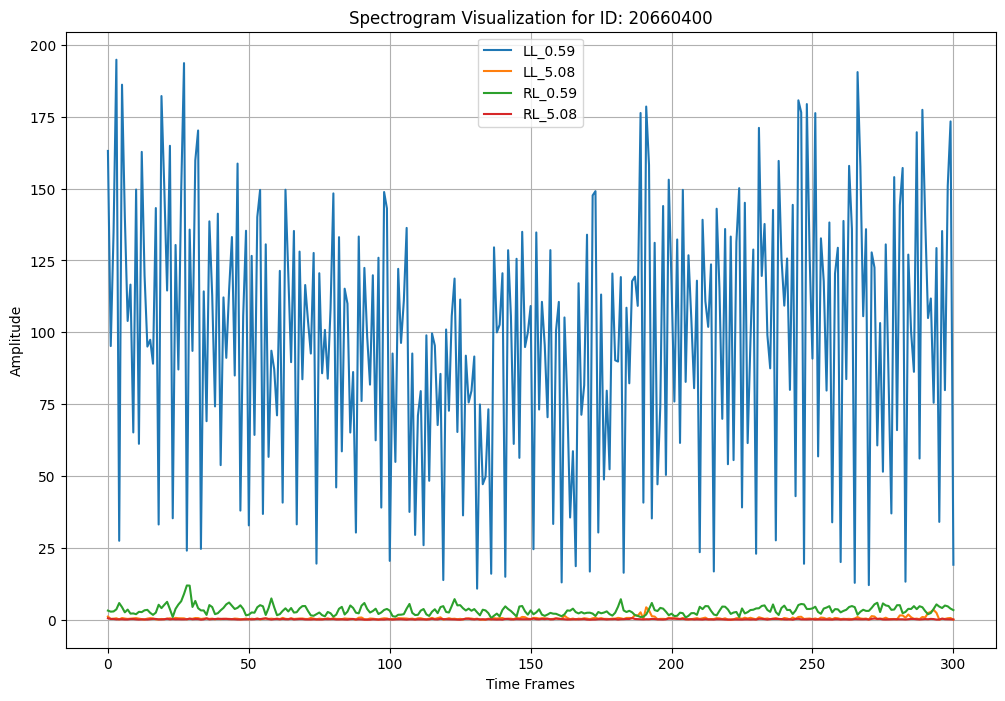

Spectrogram frame rate is:  0.5016666666666667


In [120]:
spectr_frame_rate = inspect_and_plot_spectrogram(20660400)
print("Spectrogram frame rate is: ",spectr_frame_rate )

In [121]:
print(spectr_frame_rate)
SPECTR_FRAME_PER_SECOND = round(spectr_frame_rate, 1) 
print(SPECTR_FRAME_PER_SECOND)
SPECTR_WINDOW = int(SPECTR_WINDOW_IN_SEC * SPECTR_FRAME_PER_SECOND)
print(SPECTR_WINDOW)

0.5016666666666667
0.5
5


In [122]:
def load_train(metadata):
    
    # Optionally drop unnecessary columns from the metadata
    metadata.drop(columns=[
        'expert_consensus',
        'eeg_sub_id',
        'spectrogram_sub_id',
        'patient_id',
        'label_id'
    ], inplace=True)

    # Ensure correct data types
    metadata['eeg_id'] = metadata['eeg_id'].astype(int)
    metadata['spectrogram_id'] = metadata['spectrogram_id'].astype(int)
    metadata['eeg_label_offset_seconds'] = metadata['eeg_label_offset_seconds'].astype(int)
    metadata['spectrogram_label_offset_seconds'] = metadata['spectrogram_label_offset_seconds'].astype(int)

    # Prepare a list of train_ids from the metadata, or define it explicitly
    # This could be based on some filtering criteria or simply all IDs in the dataset
    train_ids = metadata['eeg_id'].unique().tolist()  # Example to fetch unique EEG IDs

    # Debugging: Sample the data if in DEBUG mode to reduce size for faster processing
    if DEBUG:
        metadata = metadata.sample(min(DEBUG_TRAIN_SIZE, len(metadata)))

    # Instantiate the multimodal loader with the metadata and train IDs
    train_eeg_spectrogram_loader = TrainEegSpectrogramLoaderMultiModal(train_ids, metadata)
    
    # Assuming TrainTargetLoader can be appropriately initialized with the same metadata
    train_target_loader = TrainTargetLoader(metadata)

    # Return the size of the training data, the data loader, and the target loader
    return (
        len(metadata),
        train_eeg_spectrogram_loader,
        train_target_loader
    )

In [123]:
train_size, train_eeg_spectrogram_loader, train_target_loader = load_train(metadata)
print(len(train_target_loader))

512


In [124]:
class BatchSlicer:
    def __init__(self, length: int, batch_size: int = None, num_batches: int = None):
        assert length >= 0, 'Invalid length, must be >= 0'
        assert (batch_size is None) != (num_batches is None), 'Specify exactly one of batch_size or num_batches'
        assert batch_size is None or batch_size > 0, 'Invalid batch_size, must be > 0'
        assert num_batches is None or num_batches > 0, 'Invalid num_batches, must be > 0'

        self._length = length
        if num_batches is None:
            self._batch_size = batch_size
            self._num_batches = (self._length + self._batch_size - 1) // self._batch_size
        else:
            self._num_batches = num_batches
            self._batch_size = (self._length + self._num_batches - 1) // self._num_batches

        self._real_batch_size = self._length // self._num_batches
        self._remainder = self._length % self._num_batches
        self._num_full_batches = self._num_batches if self._remainder == 0 else self._num_batches - 1

    def __getitem__(self, index: int):
        if not SKIP_ASSERT:
            assert index >= 0 and index < self._num_batches, 'Invalid batch index={}, num_batches={}'.format(index, self._num_batches)
        
        if index < self._num_full_batches:
            begin = index * self._real_batch_size
            end = begin + self._real_batch_size
        else:
            begin = index * self._real_batch_size
            end = min(begin + self._real_batch_size, self._length)  # Handle last batch, possibly smaller
        return range(begin, end)

    def __len__(self):
        return self._num_batches


In [125]:
class BatchedSequence(Sequence):
    def __init__(self, source: Sequence, batch_size: int):
        self.source = source
        self.batch_size = batch_size
        self.batch_slicer = BatchSlicer(len(self.source), batch_size=batch_size)

    def __len__(self):
        return (len(self.source) + self.batch_size - 1) // self.batch_size

    def __getitem__(self, index):
        rng = self.batch_slicer[index]
        batch = [self.source[i] for i in rng]

        if isinstance(batch[0], tuple):  # Multi-modal data
            modal_batches = zip(*batch)
            stacked_batches = tuple(self.safe_stack(modal) for modal in modal_batches)
            return stacked_batches
        stacked_batch = self.safe_stack(batch)
        #print(f"Batch {index}: Shape - {stacked_batch.shape}")
        return stacked_batch

    def safe_stack(self, modal_data):
        """Stack data safely by padding to the maximum shape within the batch."""
        max_shape = tuple(max(sizes) for sizes in zip(*[data.shape for data in modal_data]))
        padded_data = [np.pad(data, [(0, max_dim - cur_dim) for cur_dim, max_dim in zip(data.shape, max_shape)],
                              mode='constant', constant_values=0) for data in modal_data]
        return np.stack(padded_data)

In [126]:
def assert_no_nan(x):
    assert not np.isnan(x).any(), 'has NAN!!!'
    return x

In [127]:
class TransformSequence(Sequence):
    def __init__(self, source: Sequence, transform):
        self.source = source
        self.transform = transform

    def __len__(self):
        return len(self.source)

    def __getitem__(self, index):
        # Apply the transform function to the data item at the specified index
        data_item = self.source[index]
        return self.transform(data_item)

In [128]:
@dataclass(frozen = True)
class JoinSequence(Sequence):
    a : Sequence
    b : Sequence
        
    def __len__(self):
        return len(self.a)
        
    def __getitem__(self, index):
        return (self.a[index], self.b[index])

In [129]:
@dataclass(frozen = True)
class AsKerasSequence(keras.utils.Sequence):
    source : Sequence
    on_epoch_end_callback : Callable = lambda : True
    
    def __len__(self):
        return len(self.source)
    
    def __getitem__(self, index):
        return self.source[index]
    
    def on_epoch_end(self):
        self.on_epoch_end_callback()

In [130]:
class SplitSubEpoches(keras.utils.Sequence):
    def __init__(self, source, num_sub_epoches):
        self.source = source
        self.num_sub_epoches = num_sub_epoches
        self.current_sub_epoch = 0
        self.slicer = BatchSlicer(len(self.source), num_batches = self.num_sub_epoches)
    
    def __len__(self):
        rng = self.slicer[self.current_sub_epoch]
        return rng.stop - rng.start
        
    def __getitem__(self, index):
        rng = self.slicer[self.current_sub_epoch]
        if index < 0 or index >= rng.stop - rng.start:
            raise IndexError()
        return self.source[rng.start + index]
        
    def on_epoch_end(self):
        self.current_sub_epoch += 1
        if self.current_sub_epoch == self.num_sub_epoches:
            self.source.on_epoch_end()
            self.current_sub_epoch = 0 

In [131]:
def make_decision(probs):
    decision = np.zeros_like(probs)
    decision[np.arange(len(probs)), probs.argmax(1)] = 1
    return decision   

In [132]:
def scale_features(data):
    data = np.transpose(data, axes=(0,2,1))
    mean = np.nanmean(data, axis = (2), keepdims = True)
    std = np.nanstd(data, axis = (2), keepdims = True)
    std[std == 0] = 1
    data = np.nan_to_num((data - mean)/std, 0, 0, 0)
    data = np.transpose(data, axes=(0,2,1))
    return data

In [133]:
def build_train_data(train_ids):
    if len(train_ids) == 0:
        return None  # Return None if there are no train_ids to process
    
    
    # Initialize the batched sequences
    train_data = BatchedSequence(train_eeg_spectrogram_loader, BATCH_SIZE)
    target_data = BatchedSequence(train_target_loader, BATCH_SIZE)
    print(len(target_data))
    # Create a combined batch sequence for inputs and targets
    if len(train_data) == 0 or len(target_data) == 0:
        print("No data available for the given IDs.")
        return None
    

    # Combine the data and target sequences
    combined_data = JoinSequence(train_data, target_data)
    
    print("Batch size:", BATCH_SIZE)
    print("Total number of batches (combined_data):", len(combined_data))

    if len(combined_data) > 0:
        (sample_eeg, sample_spectrogram), sample_targets = combined_data[0]
        print("Sample EEG data shape:", sample_eeg.shape)
        print("Sample Spectrogram data shape:", sample_spectrogram.shape)
        print("Sample target data shape:", sample_targets.shape)
    else:
        print("combined_loader size is 0")
    
    return combined_data

In [134]:
from sklearn.model_selection import train_test_split

train_ids = list([x for x in range(train_size)])

# Split data into training and validation sets if VALIDATION_FRAC is specified
if VALIDATION_FRAC > 0:
    train_ids, valid_ids = train_test_split(train_ids, test_size=VALIDATION_FRAC)
    if len(train_ids) == 0 or len(valid_ids) == 0:
        raise ValueError("Training or validation set is empty after split. Adjust the VALIDATION_FRAC or check the dataset size.")
else:
    valid_ids = None
# Build training and validation datasets using the provided IDs
train_data = build_train_data(train_ids)
valid_data = build_train_data(valid_ids) if valid_ids is not None else None

if train_data is not None:
    print("Training data prepared.")
if valid_data is not None:
    print("Validation data prepared.")

# Check the structure of the data if available
if train_data:
    print("train_data sample shapes:", [(x[0][0].shape, x[0][1].shape, x[1].shape) for x in [train_data[0]]])
if valid_data:
    print("valid_data sample shapes:", [(x[0][0].shape, x[0][1].shape, x[1].shape) for x in [valid_data[0]]])

4
Batch size: 128
Total number of batches (combined_data): 4
Sample EEG data shape: (128, 1000, 20)
Sample Spectrogram data shape: (128, 5, 400)
Sample target data shape: (128, 6)
4
Batch size: 128
Total number of batches (combined_data): 4
Sample EEG data shape: (128, 1000, 20)
Sample Spectrogram data shape: (128, 5, 400)
Sample target data shape: (128, 6)
Training data prepared.
Validation data prepared.
train_data sample shapes: [((128, 1000, 20), (128, 5, 400), (128, 6))]
valid_data sample shapes: [((128, 1000, 20), (128, 5, 400), (128, 6))]


In [135]:
def create_bimodal_model():
    # EEG branch
    # Constants from your dataset
    num_eeg_features = len(EEG_FEATURES)  # Number of EEG channels
    num_eeg_timesteps = EEG_MODEL_WINDOW  # Number of timesteps in each EEG sample
    num_spectr_features = len(SPECTR_FEATURES)  # Number of features in each Spectrogram sample
    num_spectr_timesteps = SPECTR_WINDOW  # Adjusted number of timesteps in each Spectrogram sample
    num_output_classes = len(VOTE_COLUMNS)  # Assuming 'VOTE_COLUMNS' has 10 different classes
    
    
    # EEG branch
    eeg_input = Input(shape=(num_eeg_timesteps, num_eeg_features), name='eeg_input')
    eeg_x = LSTM(64, return_sequences=True)(eeg_input)
    eeg_x = BatchNormalization()(eeg_x)
    eeg_x = LSTM(32)(eeg_x)
    eeg_x = BatchNormalization()(eeg_x)
    eeg_x = Dropout(0.5)(eeg_x)
    eeg_x = Dense(64, activation='relu')(eeg_x)

    # Spectrogram branch (Corrected shape)
    spectr_input = Input(shape=(num_spectr_timesteps, num_spectr_features, 1), name='spectr_input')
    spectr_x = Conv2D(32, (3, 3), activation='relu', padding='same')(spectr_input)
    spectr_x = BatchNormalization()(spectr_x)
    spectr_x = Conv2D(64, (3, 3), activation='relu', padding='same')(spectr_x)
    spectr_x = BatchNormalization()(spectr_x)
    spectr_x = Flatten()(spectr_x)
    spectr_x = Dense(64, activation='relu')(spectr_x)

    # Concatenate both branches
    combined = concatenate([eeg_x, spectr_x])

    # Final output layer
    combined_x = Dense(128, activation='relu')(combined)
    combined_x = Dropout(0.5)(combined_x)
    outputs = Dense(num_output_classes, activation='softmax')(combined_x)

    model = Model(inputs=[eeg_input, spectr_input], outputs=outputs)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [137]:
simple_model = create_bimodal_model()
simple_model.summary()

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:l

In [138]:
# Callbacks
class ModelCheckpoint(Callback):
    def __init__(self, filepath, monitor='val_loss', verbose=1, save_best_only=True):
        super(ModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.verbose = verbose
        self.save_best_only = save_best_only
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            return
        
        if self.save_best_only:
            if current < self.best:
                if self.verbose:
                    print(f'\nEpoch {epoch+1}: {self.monitor} improved from {self.best:.5f} to {current:.5f}, saving model to {self.filepath}')
                self.best = current
                self.model.save(self.filepath)
        else:
            if self.verbose:
                print(f'\nEpoch {epoch+1}: saving model to {self.filepath}')
            self.model.save(self.filepath)

In [139]:
import logging

# Set the TensorFlow logging level using the standard logging library
logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [140]:
class CustomTrainingLoop:
    def __init__(self, model, train_data, valid_data=None):
        self.model = model
        self.train_data = train_data
        self.valid_data = valid_data
        self.callbacks = [ModelCheckpoint(filepath='best_model.h5')]

    def fit(self, epochs):
        for epoch in range(epochs):
            print(f'\nStart of Epoch {epoch+1}')
            self.epoch = epoch

            for step, (inputs, targets) in enumerate(self.train_data):
                x_batch_train_eeg, x_batch_train_spectr = inputs
                # Make sure targets are properly formatted as tensors
                targets = tf.convert_to_tensor(targets)

                with tf.GradientTape() as tape:
                    logits = self.model([x_batch_train_eeg, x_batch_train_spectr], training=True)
                    # Ensure that logits are also tensors; sometimes manual intervention might be needed
                    logits = tf.convert_to_tensor(logits)

                    loss_value = self.model.compiled_loss(targets, logits)
                print("Logits type and shape:", type(logits), logits.shape)
                print("Targets type and shape:", type(targets), targets.shape)
                grads = tape.gradient(loss_value, self.model.trainable_weights)
                self.model.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))

            # Validation phase, if validation data is provided
            if self.valid_data:
                validation_loss = []
                for inputs, targets in self.valid_data:
                    x_batch_val_eeg, x_batch_val_spectr = inputs
                    val_logits = self.model([x_batch_val_eeg, x_batch_val_spectr], training=False)
                    val_loss = self.model.compiled_loss(targets, val_logits)
                    validation_loss.append(val_loss)

                val_loss = np.mean(validation_loss)
                print(f"\nValidation loss for epoch {epoch}: {val_loss:.4f}")

                # Call the callbacks for the end of the epoch
                for callback in self.callbacks:
                    callback.on_epoch_end(epoch, logs={'val_loss': val_loss})

In [141]:
training_loop = CustomTrainingLoop(simple_model, train_data, valid_data)

In [142]:
training_loop.fit(epochs=5)


Start of Epoch 1
